In [126]:
import tensorflow as tf
import numpy as np
import scipy.io as io

import scipy.signal as signal

from model.filter import filtfilt

from time import time
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 12, 8

In [5]:
tf.__version__

'1.1.0'

In [156]:
tf.reset_default_graph()
y = tf.placeholder(tf.float32, shape=[None, None], name='input')

#convenience functions
fs = rate = 300.
lowfreq = 5.
highfreq = 15.
window_size = 300
lowpass = signal.butter(4, highfreq/(rate/2.), 'low')
highpass = signal.butter(4, lowfreq/(rate/2), 'high')

def getconst(constant, **kwargs):
    #return tf.Variable(constant, trainable=False, dtype=tf.float32, **kwargs)
    return tf.constant(constant, dtype=tf.float32, **kwargs)
    
def detect_beats_tf(
        y,    # The raw ECG signal
        rate=fs,    # Sampling rate in HZ
        # Window size in seconds to use for 
        ransac_window_size=5.0,
        # Low frequency of the band pass filter
        lowfreq=5.0,
        # High frequency of the band pass filter
        highfreq=15.0,
        ):
    

    with tf.name_scope('lowpass'):
        b_LPF = getconst(lowpass[0])
        a_LPF = getconst(lowpass[1])
        y_LP = filtfilt(b_LPF, a_LPF, y)

    with tf.name_scope('highpass'):
        b_HPF = getconst(highpass[0])
        a_HPF = getconst(highpass[1])
        y_BAND = filtfilt(b_HPF, a_HPF, y_LP)
        
    with tf.name_scope('diff_power'):
        b_DEV = getconst([1/3.6, 0, 1/8, 0, -1/8, 0, -1/3.6])
        a_DEV = getconst([1, 0, 0, 0, 0])
        y_DEV = filtfilt(b_DEV, a_DEV, y_BAND)
        y_DPOW = y_DEV ** 2
    
    with tf.name_scope('thresholding'):
        window = [1, 1, window_size, 1]
        y_MAXs = tf.nn.max_pool([y_DPOW], window, window, 'VALID')[0]
        # Mean averaging the maxes
        y_MEAN_MAX = tf.nn.moments(y_MAXs, axes=[1])[0]
        y_MIN_MAX = tf.reduce_min(y_MAXs, axis=1)
        y_MEAN, y_STD = tf.nn.moments(y_DPOW, axes=[1])
        """
        y_DPOW = tf.where(
            (y_DPOW > y_MEAN_MAX), tf.zeros_like(y_DPOW), y_DPOW)
        y_DP_NORM = y_DPOW / y_MEAN_MAX
        y_THR = tf.where(
            (y_DP_NORM > 1), tf.ones_like(y_DP_NORM), y_DP_NORM)
        """
        y_SQP = y_DPOW ** 2 
        y_SHANNON = -y_SQP * tf.log(y_SQP)
        y_SHANNON = tf.where(
            tf.is_nan(y_SHANNON), tf.zeros_like(y_SHANNON), y_SHANNON)
        y_LP = filtfilt(b_LPF, a_LPF, y_SHANNON)
    return y_LP, y_MAXs, y_MIN_MAX, y_MEAN_MAX
        
def loadmat(id):
    fname = "data/raw/training2017/A%05d.mat"%id
    y_val = io.loadmat(fname)['val'][0]
    return y_val

In [161]:
test_op = detect_beats_tf(y)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
t = time()
res = sess.run(test_op, {y:[loadmat(3)]})
time() - t

17.038361310958862

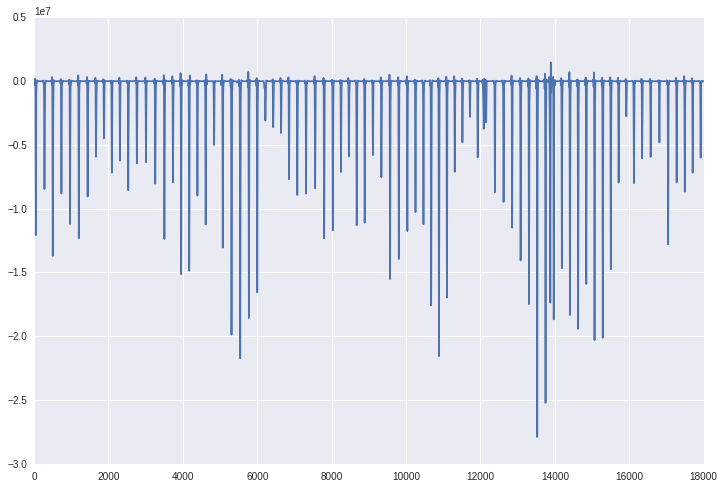

In [162]:
plt.plot(res[0].squeeze())
#plt.plot(np.repeat(res[1].squeeze(), window_size))
#plt.plot(np.ones(9000)*(res[2].squeeze()))
plt.show()
#%matplotlib notebook
#plt.plot(res[3].squeeze())

<IPython.core.display.Javascript object>


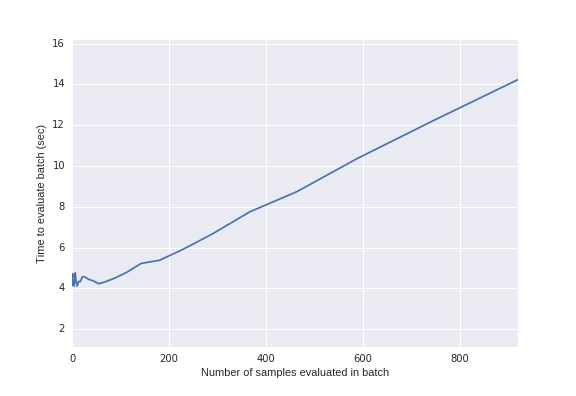

In [68]:
#plt.plot(list(zip(evtimes, np.logspace(0, 4, num=40))))

sample_nums = np.logspace(0, 4, num=40)
%matplotlib notebook
plt.plot(sample_nums, evtimes)
plt.xlabel('Number of samples evaluated in batch')
plt.ylabel('Time to evaluate batch (sec)')

In [97]:
def evtime_for_n_samples(op, n=1, repeat=4):
    y_val = [loadmat(1)]*n
    
    res = []
    for _ in range(repeat):
        t = time()
        op.eval({y:y_val})
        res.append(time() - t)
    return res

'''evtimes = []
for i in np.logspace(0, 4, num=40):
    res_time = evtime_for_n_samples(int(i))
    print(int(i), res_time)
    evtimes.append(res_time)'''

'evtimes = []\nfor i in np.logspace(0, 4, num=40):\n    res_time = evtime_for_n_samples(int(i))\n    print(int(i), res_time)\n    evtimes.append(res_time)'

In [ ]:
num_samples = np.logspace(0, 2, num=100)*2
evtimes = {int(num):0 for num in num_samples}
eval_nums = {int(num):0 for num in num_samples}
for i in num_samples:
    res_time = evtime_for_n_samples(int(i))
    print(int(i), res_time)
    evtimes[int(i)] += res_time
    eval_nums[int(i)] += 1

2 4.3746617436409
2 4.270411729812622
2 4.295275270938873
2 4.28721809387207
2 4.332800447940826
2 4.314619302749634
2 4.374687314033508
2 4.318858444690704
2 4.312534272670746
3 4.557827472686768
3 4.200119435787201
3 4.296200215816498
3 4.260851979255676
3 4.3715309500694275
3 4.351549506187439
4 4.408352494239807
4 4.31701922416687
4 4.369952440261841
4 4.353632271289825
4 5.046527862548828
5 4.380912899971008
5 4.40529990196228
5 4.789647459983826
5 4.605475068092346
6 4.676575124263763
6 4.2864298820495605
6 4.459696054458618
7 4.524575769901276
7 4.478616833686829
7 4.612408399581909
8 4.530240178108215
8 4.555855810642242
8 4.513126611709595
9 4.431209444999695
9 4.278194963932037
10 4.448546946048737
10 4.47949606180191
11 4.42672073841095
11 4.347829699516296
12 4.4162768721580505
12 4.436921656131744
13 4.545829713344574
14 4.473288893699646
14 4.454797804355621
15 4.718720555305481
16 4.528357923030853
16 4.625146508216858
17 4.519965171813965
18 4.628142297267914
19 4.64335

<IPython.core.display.Javascript object>


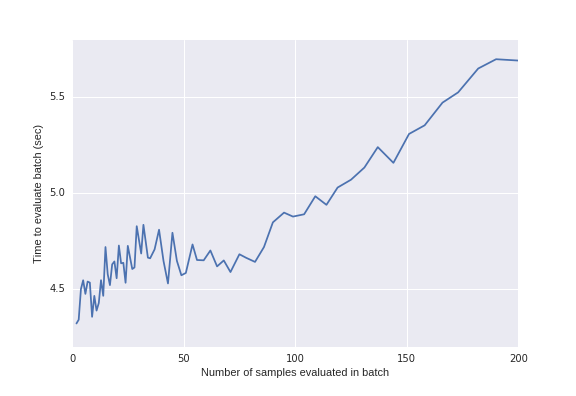

In [96]:
num_ticks = list(eval_nums.keys())
num_ticks.sort()
avg_evtimes = [evtimes[num]/eval_nums[num] for num in num_ticks]

%matplotlib notebook
plt.plot(num_ticks, avg_evtimes)
plt.xlabel('Number of samples evaluated in batch')
plt.ylabel('Time to evaluate batch (sec)')